# Background, motivation and set up

*Objective*: investigate the relationship between attribution scores and output gradients, and utilise this relationship to generate the "optimal" counterfactual inputs such that a specific model component will be assigned high attribution scores by IG/AP.

In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import torch
import numpy as np

from captum.attr import LayerIntegratedGradients
from captum.attr._utils.approximation_methods import approximation_parameters

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)
n_steps = 50

Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
#| output: true

clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_input = model.to_tokens(clean_prompt)
corrupted_input = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

clean_logits, clean_cache = model.run_with_cache(clean_input)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 4.276
Corrupted logit difference: -2.738


In [33]:
def run_from_layer_fn(x, original_input, prev_layer, reset_hooks_end=True):
    # Force the layer before the target layer to output the given values, i.e. pass the given input into the target layer
    # original_input value does not matter; useful to keep shapes nice, but its activations will be overwritten
    
    # Do not backpropagate before the target layer
    torch.set_grad_enabled(False)

    def fwd_hook(act, hook):
        torch.set_grad_enabled(True)
        x.requires_grad = True
        return x
    
    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(prev_layer.name, fwd_hook)],
        reset_hooks_end=reset_hooks_end
    )
    logit_diff = logits_to_logit_diff(logits).unsqueeze(0)
    return logit_diff

In [91]:
def get_layer_baseline_inputs(target_layer_num, target_pos, clean_cache, corrupt_cache):
    hook_name = get_act_name("result", target_layer_num)
    target_layer = model.hook_dict[hook_name]

    layer_baseline = clean_cache[hook_name] # Baseline
    
    layer_input = layer_baseline.clone()
    layer_input[:, :, target_pos] = corrupt_cache[hook_name][:, :, target_pos]

    return layer_baseline, layer_input, target_layer

# Gradients with respect to interpolated inputs

We take the change in model output with respect to the interpolated input at the target component. We quantify the change in gradients as the maximum range of gradients.

In [ ]:
def interpolate_from_layer_fn(layer_baseline, layer_input, alpha, original_input, prev_layer, reset_hooks_end=True):
    # Force the layer before the target layer to output the given values, i.e. pass the given input into the target layer
    # original_input value does not matter; useful to keep shapes nice, but its activations will be overwritten
    
    # Do not backpropagate before the target layer
    torch.set_grad_enabled(False)

    def fwd_hook(act, hook):
        torch.set_grad_enabled(True)
        x = layer_baseline + alpha * (layer_input - layer_baseline)
        return x
    
    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(prev_layer.name, fwd_hook)],
        reset_hooks_end=reset_hooks_end
    )
    logit_diff = logits_to_logit_diff(logits).unsqueeze(0)
    return logit_diff


def attn_interpolated_gradients(target_layer_num, target_pos):
    # Get the baseline inputs
    layer_baseline, layer_input, target_layer = get_layer_baseline_inputs(target_layer_num, target_pos, clean_cache, corrupted_cache)

    # Get interpolated inputs according to step sizes
    _, alphas_func = approximation_parameters("gausslegendre")
    alphas = alphas_func(n_steps)

    # Calculate gradient of output with respect to interpolated inputs at target attention head
    _, seq_len, _, d_model = layer_input.shape
    grad_history = torch.zeros((n_steps,))
    outputs = []

    model.reset_hooks()

    for idx, alpha in enumerate(alphas):
        alpha = torch.tensor(alpha, requires_grad=True)
        # Do not reset hooks until after backpropagation has happened
        output = interpolate_from_layer_fn(layer_baseline, layer_input, alpha, clean_input, target_layer, reset_hooks_end=False)
        outputs.append(output)
        
        grad = torch.autograd.grad(output, alpha)[0]
        model.reset_hooks()

        grad_history[idx] = grad

    # grad_history = grad_history.unsqueeze(2)

    return alphas, grad_history, outputs

    # ALTERNATIVE IMPLEMENTATION: CHECK RESULTS
    # with torch.autograd.set_grad_enabled(True):
    #     outputs = forward_fn(interpolated_inputs)
    #     grads = torch.autograd.grad(outputs, interpolated_inputs)[0] # Shape (n_steps, seq_len, n_heads, d_model)
    #     model.reset_hooks()

    #     # Take the gradient at target attention head
    #     grad_history = grads[:, :, target_pos, :]


def quantify_gradients_range(mean_grad_history):
    # Expected input shape: (n_steps, 1)
    max_grad = torch.max(mean_grad_history)
    min_grad = torch.min(mean_grad_history)
    return max_grad - min_grad

In [124]:
def visualise_attn_interpolated_outputs(target_layer_num, target_pos):
    layer_clean_input, layer_corrupt_input, target_layer = get_layer_baseline_inputs(target_layer_num, target_pos, clean_cache, corrupted_cache)

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, clean_input, target_layer)
    _, alphas_func = approximation_parameters("gausslegendre")
    alphas = alphas_func(n_steps)

    # interpolated_inputs = [layer_clean_input + alpha * (layer_corrupt_input - layer_clean_input) for alpha in alphas]
    # outputs = [forward_fn(i) for i in interpolated_inputs]
    model.reset_hooks()
    outputs = [interpolate_from_layer_fn(layer_clean_input, layer_corrupt_input, alpha, clean_input, target_layer, reset_hooks_end=True) for alpha in alphas]

    print(outputs)

    plt.title(f"Model output at interpolated gradients: head {(target_layer_num, target_pos)}")
    plt.plot(alphas, [o.item() for o in outputs])
    plt.xlabel("Interpolation coefficient")
    plt.ylabel("Output (logit difference)")
    plt.ylim(0, 6)
    plt.show()

We visualise the change in gradients for a specific attention head, and compare it to the shape of its output. We also check that the gradients range makes sense.

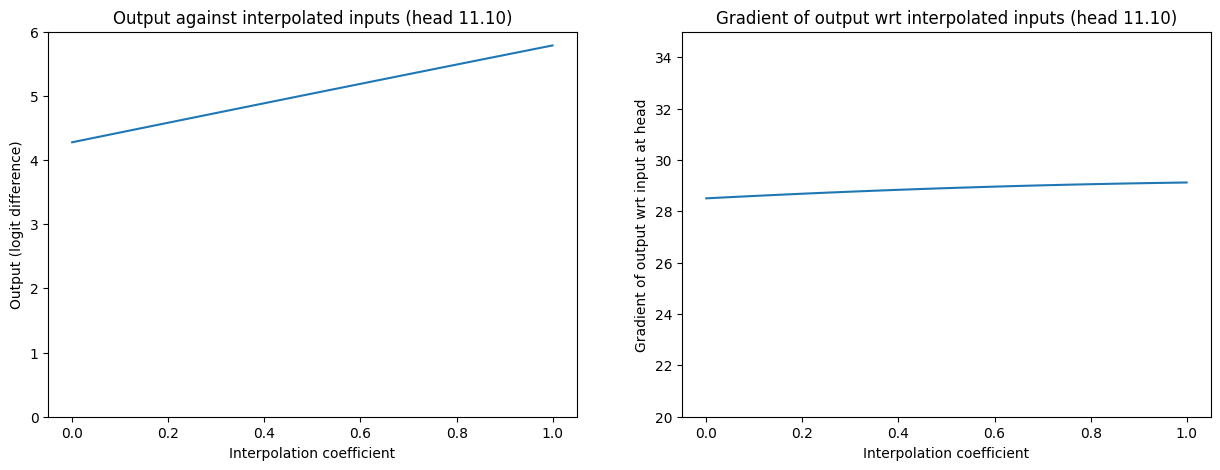

tensor(0.6172)


In [121]:
alphas, grad_history_1110, outputs_1110 = attn_interpolated_gradients(target_layer_num=11, target_pos=10)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title("Output against interpolated inputs (head 11.10)")
plt.plot(alphas, [o.item() for o in outputs_1110])
plt.xlabel("Interpolation coefficient")
plt.ylabel("Output (logit difference)")
plt.ylim(0, 6)

plt.subplot(1, 2, 2)
plt.title(f"Gradient of output wrt interpolated inputs (head 11.10)")
plt.plot(alphas, grad_history_1110.detach())
plt.xlabel("Interpolation coefficient")
plt.ylabel("Gradient of output wrt input at head")
plt.ylim(20, 35)

plt.show()

print(quantify_gradients_range(grad_history_1110))

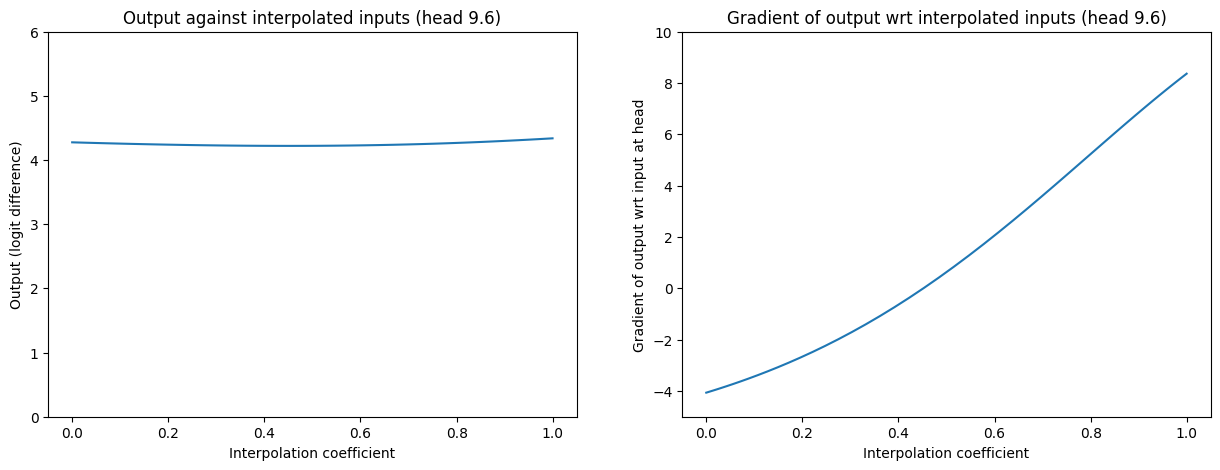

tensor(12.4272)


In [122]:
alphas, grad_history_96, outputs_96 = attn_interpolated_gradients(target_layer_num=9, target_pos=6)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title("Output against interpolated inputs (head 9.6)")
plt.plot(alphas, [o.item() for o in outputs_96])
plt.xlabel("Interpolation coefficient")
plt.ylabel("Output (logit difference)")
plt.ylim(0, 6)

plt.subplot(1, 2, 2)
plt.title(f"Gradient of output wrt interpolated inputs (head 9.6)")
plt.plot(alphas, grad_history_96.detach())
plt.xlabel("Interpolation coefficient")
plt.ylabel("Gradient of output wrt input at head")
plt.ylim(-5, 10)

plt.show()

print(quantify_gradients_range(grad_history_96))

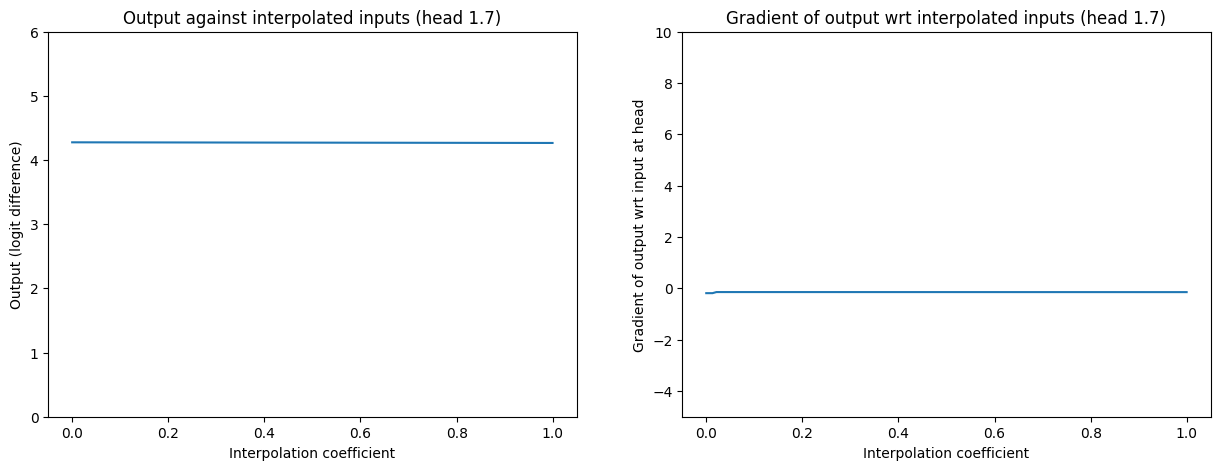

tensor(0.0426)


In [123]:
alphas, grad_history_17, outputs_17 = attn_interpolated_gradients(target_layer_num=1, target_pos=7)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title("Output against interpolated inputs (head 1.7)")
plt.plot(alphas, [o.item() for o in outputs_17])
plt.xlabel("Interpolation coefficient")
plt.ylabel("Output (logit difference)")
plt.ylim(0, 6)

plt.subplot(1, 2, 2)
plt.title(f"Gradient of output wrt interpolated inputs (head 1.7)")
plt.plot(alphas, grad_history_17.detach())
plt.xlabel("Interpolation coefficient")
plt.ylabel("Gradient of output wrt input at head")
plt.ylim(-5, 10)

plt.show()

print(quantify_gradients_range(grad_history_17))

Overall, the visualisation of the output reveals that the key difference in attribution scores lies in the shape of output between the two input pairs.

* If the output difference between the start and end inputs is zero, activation patching will not highlight the component. However, it is possible that the output fluctuates between the two inputs but returns to the same starting point, in which case only integrated gradients will attribute a higher/lower score.
* This explains why head 9.6 has zero attribution under activation patching, but non-zero attribution under integrated gradients.

Additionally, based on work [investigating saturation effects in integrated gradients](https://arxiv.org/abs/2010.12697), IG can overestimate the importance of components if the shape of the output is saturated at either end.

* Restricting integrated gradients to only areas in which output changes substantially decreases the amount of noise in attributions. This leads to higher model faithfulness and lower sensitivity to input perturbations.

## Sanity check: output difference for attention heads

The difference in model outputs for the two contrastive inputs corresponds exactly to the activation patching attribution scores by definition.

In [127]:
def output_difference(target_layer_num, target_pos):
    layer_clean_input, layer_corrupt_input, target_layer = get_layer_baseline_inputs(target_layer_num, target_pos, clean_cache, corrupted_cache)

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, clean_input, target_layer)
    _, alphas_func = approximation_parameters("gausslegendre")
    alphas = alphas_func(n_steps)

    interpolated_inputs = [layer_clean_input + alpha * (layer_corrupt_input - layer_clean_input) for alpha in alphas]
    outputs = torch.tensor([forward_fn(i) for i in interpolated_inputs])

    max_output = torch.max(outputs)
    min_output = torch.min(outputs)
    return max_output - min_output

In [128]:
output_difference_1110 = output_difference(11, 10)
output_difference_96 = output_difference(9, 6)
output_difference_17 = output_difference(1, 7)

print(f"Output difference for head 11.10: {output_difference_1110}")
print(f"Output difference for head 9.6: {output_difference_96}")
print(f"Output difference for head 1.7: {output_difference_17}")

Output difference for head 11.10: 1.508988380432129
Output difference for head 9.6: 0.11768531799316406
Output difference for head 1.7: 0.01003265380859375


### Correlation between output difference and activation patching scores

We quantify the range in outputs across all attention heads, and compare it to the activation patching score.

In [129]:
attn_patch_results = torch.load("attn_patch_results.pt")

In [130]:
attn_output_diff = torch.empty((model.cfg.n_layers, model.cfg.n_heads))

for layer_idx in range(model.cfg.n_layers):
    for head_idx in range(model.cfg.n_heads):
        attn_output_diff[layer_idx, head_idx] = output_difference(layer_idx, head_idx)

In [134]:
torch.save(attn_output_diff, "attn_output_diff.pt")

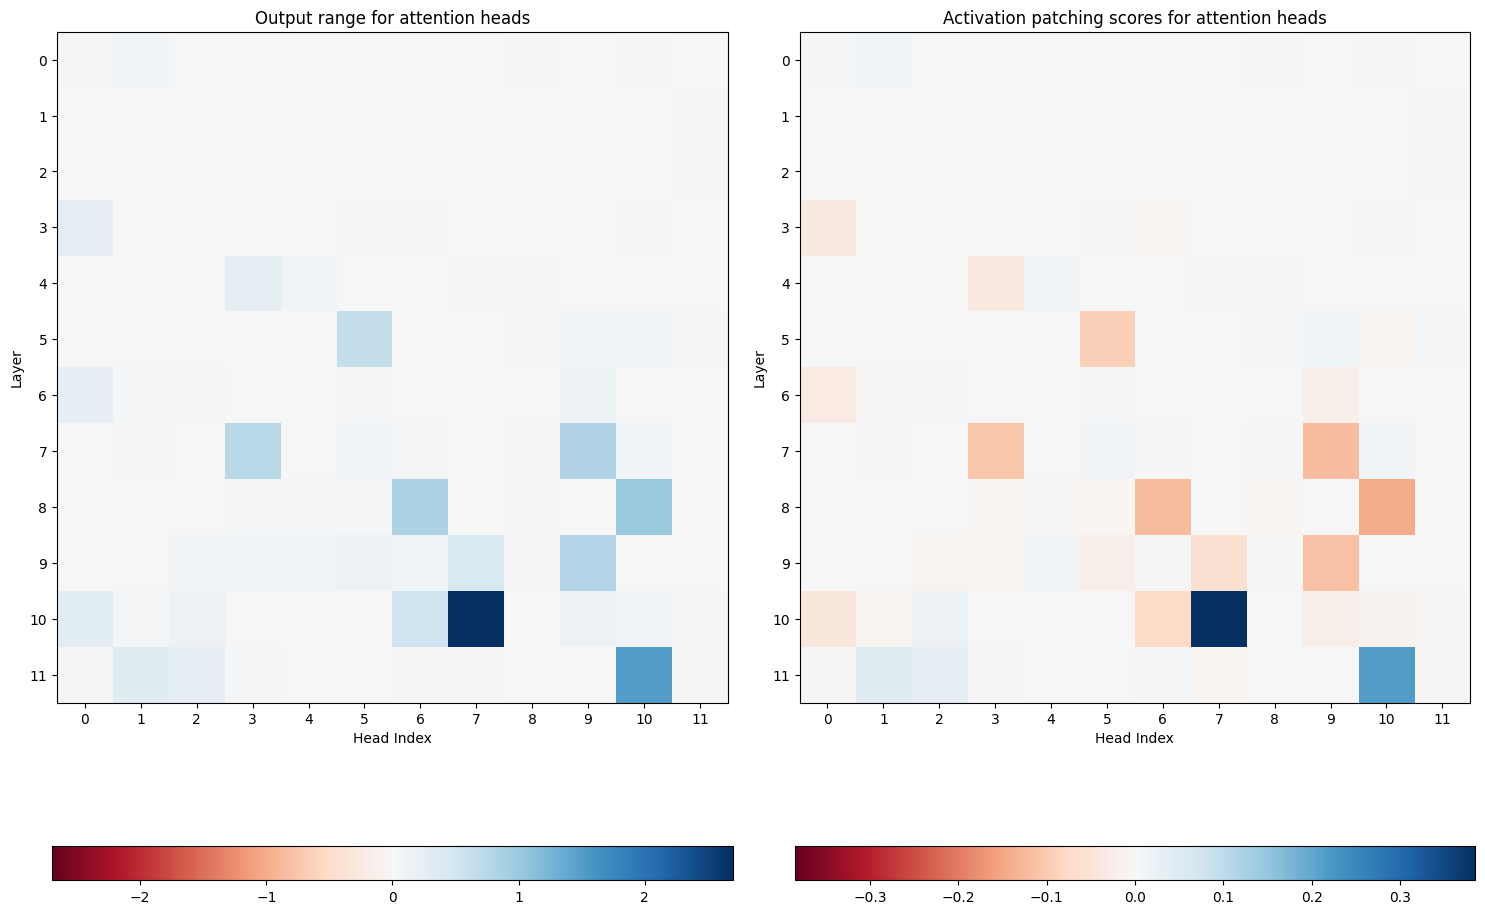

In [138]:
# Plot gradient ranges and activation patching scores side-by-side
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)

output_range_bound = torch.max(torch.abs(attn_output_diff))

plt.title("Output range for attention heads")
plt.imshow(attn_output_diff.detach(), cmap="RdBu", vmin=-output_range_bound, vmax=output_range_bound)
plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))
plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))
plt.colorbar(orientation="horizontal")

plt.subplot(1, 2, 2)

patch_bound = torch.max(torch.abs(attn_patch_results))

plt.title("Activation patching scores for attention heads")
plt.imshow(attn_patch_results.detach(), cmap="RdBu", vmin=-patch_bound, vmax=patch_bound)
plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))
plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))
plt.colorbar(orientation="horizontal")

plt.tight_layout()
plt.show()

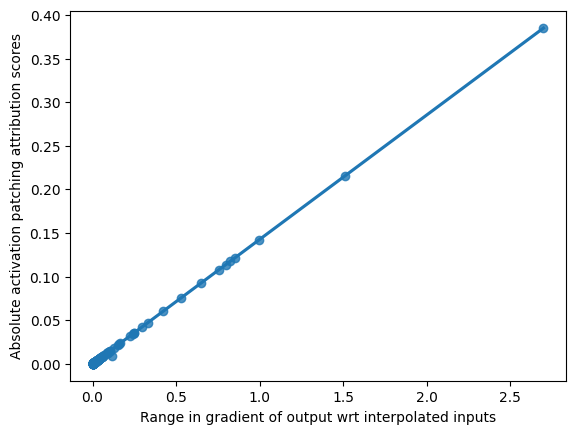

Correlation coefficient between gradient range and absolute activation patching score: 0.3742223382467527


In [142]:
# Plot correlation between gradient range and activation patching score

attn_output_ranges_1d = attn_output_diff.flatten().numpy()
attn_abs_patch_results_1d = torch.abs(attn_patch_results).flatten().numpy()

sns.regplot(x=attn_output_ranges_1d, y=attn_abs_patch_results_1d)
plt.xlabel("Range in gradient of output wrt interpolated inputs")
plt.ylabel("Absolute activation patching attribution scores")
plt.show()

print(f"Correlation coefficient between gradient range and absolute activation patching score: {np.corrcoef(attn_output_ranges_1d, attn_patch_results_1d)[0, 1]}")

# Contrastive pair generation

## Preamble: results so far

From prior experiments, we can conclude that:

* The choice of contrastive inputs (baseline vs input for IG, or clean vs corrupt for AP) affects attribution scores greatly, as the two methods are implicitly reliant on counterfactual reasoning.
* IG and AP largely agree when their contrastive inputs agree.

The discrepancies between IG and AP are characterised by the shape of the output curve.

* Discrepancies in IG and AP attribution scores are caused by a non-linear output curve which returns to the same output value along the straightline path between contrastive inputs.
* Attribution scores from AP correspond exactly to the difference in outputs between contrastive inputs, when patching into a specific component.
* Faithfulness and stability of IG attribution increases if the output curve along the straightline path does not contain saturated regions.

Based on these results, we can leverage the counterfactual reasoning underlying these methods, to identify the "optimal" contrastive pair which would cause a target model component to have high attribution scores under both IG and AP.

### Motivation

Generating the counterfactuals which yield a high attribution score for a given model component can:

* Provide counterfactual explanations for specific model components, which may be more human-interpretable than existing methods, e.g. top activating tokens, or SAEs
* Unify attribution scores from activation patching and integrated gradients
* Deepen understanding of how specific circuit components contribute to the circuit's task
* Support the design of contrastive templates used to test specific behaviours

## Objectives

To generate the optimal contrastive pair for a high attribution score, we aim to satisfy the following objectives:

* Maximise difference in output logits between candidate input pair: maps directly to attribution score for activation patching
* Preserve change in output along region between candidate inputs: avoid saturated regions during IG interpolation
* Maximise similarity in candidate pair inputs: minimal perturbation to inputs for interpretable counterfactuals
* Minimise perplexity of candidate input pair: ensure contrastive pairs are realistic (in model input distribution).

As we are dealing with a language model where tokens map to discrete embedding vectors, we use ideas from discrete optimisation methods such as [PEZ](https://arxiv.org/abs/2302.03668) (largely in the realm of prompt generation for text-to-image models):

* We make use of a forward projection function, which finds the most similar vector in the model's embedding matrix to the given continuous embedding vector.
* We optimise over continuous embedding vectors, but calculate the gradient / optimisation step wrt to the projected embedding.

## Evolutionary algorithm

Since we want to optimise the above objectives simultaneously, we use an evolutionary strategy with the following setup:

* The population consists of candidate pairs of continuous-valued vectors `(x,y)`.
* The fitness of a candidate pair is `(a, b, c, d)` where `a` is the difference between model output logits, `b` is the gradient of the output at each input, `c` is the similarity between the projected vectors, and `d` is the negative perplexity of the pair.
* The behavioural descriptor is the projection of the embedding vector onto the nearest tokens in the model vocabulary.

The algorithm is as follows:

1. Start from a singular text input, from which the contrastive pair will be generated.
2. Initialise the population with pairs of embeddings `(x,y)`, generated by randomly perturbing the input embedding.
3. Calculate the fitness of each candidate pair in the population.
    - Compute `a`, the output logit difference: two forward passes (patching into target model component).
    - Compute `b`, the gradient of the output at `x` and at `y`: two backward passes.
    - Project the continuous embeddings `(x,y)` to their nearest tokens `(x', y')`: time complexity `O(2 * d_vocab * d_model)`.
    - Compute `c`, the similarity between the projected tokens `x'` and `y'`.
    - Compute `d`, the perplexity of `x` and `y` for the model: time complexity `O(2 * seq_len)`.
4. Select the top K samples based on their fitness, and mutate them based on the gradients in `b`.
    - For selection, use NSGA-III (non-dominated sorting genetic algorithm) to maximise all four fitness objectives simultaneously.
    - For mutation, add noise to `x` and to `y`.
5. Replace the worst K samples in the popoulation with the mutated samples.
6. Iteratively repeat steps 3-5 until the output logit difference is greater than threshold `T = 10` (arbitrarily set, based on experiment values).

## Gradient descent algorithm

An alternative solution would be to apply discrete gradient descent to a loss function which consists of a weighted sum of the four objectives. However, it is likely that some of these objectives conflict with each other, e.g. maximising the output difference is likely in conflict with minimising input difference, since the output difference and input difference probably have a proportional relationship.

Therefore, standard gradient descent may result in some conditions being fulfilled at the expense of other conditions, which is not desirable. In our case, we wish to solve a multi-objective optimisation problem - common solutions in the literature use evolutionary algorithms and Pareto optimisation. We instead can use a [multiple gradient descent algorithm (MGDA)](https://www.sciencedirect.com/science/article/pii/S1631073X12000738) to optimise all four objectives without improving one at the expense of another.

The algorithm is as follows:

1. Start from a singular text input `t`, from which contrastive pairs will be generated. Initialise the values of the contrastive pair `(x,y)` as `x = y = t`.
2. Calculate the following objectives (same as evolutionary algorithm):
    - Compute `a`, the output logit difference: two forward passes (patching into target model component).
    - Compute `b`, the gradient of the output at `x` and at `y`: two backward passes.
    - Project the continuous embeddings `(x,y)` to their nearest tokens `(x', y')`: time complexity `O(2 * d_vocab * d_model)`.
    - Compute `c`, the similarity between the projected tokens `x'` and `y'`.
    - Compute `d`, the perplexity of `x` and `y` for the model: time complexity `O(2 * seq_len)`.
3. Compute the gradients of the losses of each objective.
4. Update each continuous embedding `(x, y)` using MGDA.

Advantages of a gradient-based approach:
* Simpler algorithm. No need to calculate additional metrics related to the Pareto frontier, as MGDA provably converges to a Pareto stationary point.
* Efficiency. [Sener and Koltun (2019)](https://arxiv.org/pdf/1810.04650) provide an optimiser based on MGDA that can be computed via a single backward pass.

Disadvantages of a gradient-based approach:
* Potentially less variety in terms of contrastive pair results.
* Tricky to perform gradient descent on objective `b`, which depends on the gradient.
    * Solution: approximate the output gradients near the contrastive inputs by taking the output at some distance away from the input. 

In [322]:
from transformer_lens.utils import get_device
from transformer_lens import HookedTransformer

# device = get_device()
device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

start_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"

Loaded pretrained model gpt2-small into HookedTransformer


In [331]:
from counterfactual_generation import counterfactuals

target_hook_name = get_act_name("result", 11)
target_layer = model.hook_dict[target_hook_name]

counterfactuals(start_prompt, model, target_layer, 10, iterations=1)

Correct answer:  do
Output diff: tensor([0.], grad_fn=<UnsqueezeBackward0>)
Losses: (torch.Size([1]), torch.Size([2, 1, 17, 768]), torch.Size([1, 17]))
<UnsqueezeBackward0 object at 0x1cec46d10> <StackBackward0 object at 0x1cec47a90> <SumBackward1 object at 0x1cec47400>
True True
None None


: 

In [277]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h